<h3> Imports

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from collections import defaultdict
import difflib

In [35]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

<h3> EDA

In [36]:
print("data:")
display(data.head(2))

print()
print("data_by_genres:")
display(genre_data.head(2))

print()
print("data_by_year:")
display(year_data.head(2))

print()
print("data_by_artist:")
display(artist_data.head(2))

data:


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936



data_by_genres:


,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.3616,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.1310,-16.854000,0.076817,120.285667,0.221750,52.500000,5



data_by_year:


,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.20571,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.24072,-19.275282,0.116655,100.884521,0.535549,0.140845,10



data_by_artist:


,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690,0.176212,103.044154,0.268865,30.576923,5


In [37]:
print("data info: ")

print(f"Any Null Data Found: {data.isnull().any().any()}")
print()

print(data.dtypes)
data.describe()

data info: 
Any Null Data Found: False

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object


,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [38]:
print("Genre Data Info: ")

print(f"Any Null Data Found: {genre_data.isnull().any().any()}")
print()

print(genre_data.dtypes)
genre_data.describe()

Genre Data Info: 
Any Null Data Found: False

mode                  int64
genres               object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object


,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,2973.000000,2973.000000,2973.000000,2.973000e+03,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000
mean,0.833165,0.401241,0.537187,2.517209e+05,0.561143,0.211366,0.192800,-10.509848,0.083588,119.018723,0.492748,39.919185,5.938782
std,0.372891,0.319760,0.150668,9.465686e+04,0.234486,0.267329,0.092356,5.369202,0.080483,17.469188,0.201820,16.748723,3.368110
min,0.000000,0.000003,0.056900,3.094600e+04,0.001002,0.000000,0.022200,-41.825000,0.023800,47.135722,0.003353,0.000000,0.000000
25%,1.000000,0.119050,0.441202,2.063788e+05,0.395058,0.004835,0.137687,-12.427656,0.044900,109.198143,0.348578,32.491279,3.000000
50%,1.000000,0.321745,0.546496,2.375453e+05,0.601195,0.080700,0.178764,-9.221817,0.059457,119.194167,0.500048,43.056569,7.000000
75%,1.000000,0.673991,0.647500,2.772720e+05,0.730127,0.343333,0.220856,-6.920125,0.091000,127.508750,0.640257,51.138889,9.000000
max,1.000000,0.996000,0.929000,2.382587e+06,0.994667,0.992000,0.960000,0.060000,0.946219,204.212000,0.980000,80.666667,11.000000


In [39]:
print("Year Data Info: ")

print(f"Any Null Data Found: {year_data.isnull().any().any()}")
print()

print(year_data.dtypes)
year_data.describe()

Year Data Info: 
Any Null Data Found: False

mode                  int64
year                  int64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object


,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000
mean,1.0,1970.500000,0.556317,0.536783,227296.752234,0.452705,0.193582,0.208224,-11.969054,0.105861,116.015674,0.532120,27.376065,3.7900
std,0.0,29.011492,0.275358,0.052356,25630.048065,0.161738,0.122488,0.017903,3.105610,0.082128,5.669645,0.057809,20.703197,3.5627
min,1.0,1921.000000,0.219931,0.414445,156881.657475,0.207948,0.016376,0.168450,-19.275282,0.049098,100.884521,0.379327,0.140845,0.0000
25%,1.0,1945.750000,0.289516,0.500800,210889.193536,0.280733,0.103323,0.197509,-14.189232,0.064244,111.718626,0.497174,3.298200,0.0000
50%,1.0,1970.500000,0.459190,0.540976,235520.850833,0.495997,0.127644,0.206074,-11.773061,0.085763,117.455548,0.541503,33.619250,2.0000
75%,1.0,1995.250000,0.856711,0.570948,247702.738058,0.598008,0.276707,0.218493,-9.950542,0.104438,120.606644,0.570080,44.943375,7.0000
max,1.0,2020.000000,0.962607,0.692904,267677.823086,0.681778,0.581701,0.264335,-6.595067,0.490001,124.283129,0.663725,65.256542,10.0000


In [40]:
print("Artist Data Info: ")

print(f"Any Null Data Found: {artist_data.isnull().any().any()}")
print()

print(artist_data.dtypes)
artist_data.describe()

Artist Data Info: 
Any Null Data Found: False

mode                  int64
count                 int64
acousticness        float64
artists              object
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object


,mode,count,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,28680.000000,28680.000000,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.759170,13.847211,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901
std,0.427595,53.372544,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552
min,0.000000,1.000000,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110363,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000
50%,1.000000,3.000000,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000
75%,1.000000,8.000000,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000
max,1.000000,3169.000000,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000


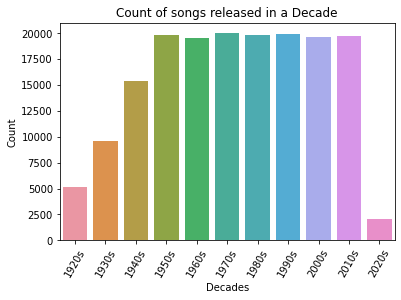

In [53]:
#create decades column feature engineering
data["decade"] = data["year"].apply(lambda year : f"{(year//10)*10}s")

#graph it
sns.countplot(x= data['decade'])

#labels and title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Count of songs released in a Decade')

#rotate x vertically
plt.xticks(rotation=60)

# Show the plot
plt.show()

In [70]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'valence']
fig = px.line(year_data, x = 'year', y = sound_features, title='Trend of various sound features over decades')
fig.show()

In [61]:
fig = px.line(year_data, x='year', y='loudness',title='Trend of loudness over decades')
fig.show()

In [62]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group',
            title='Trend of various sound features over top 10 genres')
fig.show()

In [63]:
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')

print('Top 10 Artists that produced most songs:')
top10_most_song_produced_artists[['count','artists']].sort_values('count',ascending=False)

Top 10 Artists that produced most songs:


,count,artists
8367,3169,Francisco Canaro
28561,2422,Эрнест Хемингуэй
28560,2136,Эрих Мария Ремарк
8434,1459,Frank Sinatra
10714,1256,Ignacio Corsini
27109,1200,Vladimir Horowitz
1682,1146,Arturo Toscanini
2707,1103,Billie Holiday
12378,1061,Johnny Cash
7426,1023,Elvis Presley


In [ ]:
"""
Conclusions:
    Data is clean.
    
    
"""